In [ ]:
#mounting Google drive
from google.colab import drive
drive.mount('/drive')

In [ ]:
#go to research folder and compile protobuff in research folder to use model files inside it.
%cd /drive/MyDrive/Housedamage/models/research/
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
#install tf_slim as explained in training file
!pip install tf_slim

In [ ]:
#import libraries no need to install any other library
import os
import pathlib
import numpy as np
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [ ]:
#import these file from object_detection-> utlis folder inside research folder to visualize the training
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [ ]:
#use tensorflow compactness with tensorflow 2.4 in this nootebook
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1
#TensorFlow exports these as tf. gfile , so that you can use these implementations for loading checkpoints,
#and accessing training data (among other uses).
#However, if all of your files are local, you can use the regular Python file API without any problem.
# Patch the location of gfile
tf.gfile = tf.io.gfile

In [ ]:
#this is the function we MADE TO LOAD OUR Trained model we just pass the path to it reseatch folder
#we make a variable name model_name which is used in next cell and we cancatinate it with our saved mode
def load_model(model_name):
  model = tf.saved_model.load(str("/drive/MyDrive/Housedamage/models/research/"+model_name + "/saved_model"))
  model = model.signatures['serving_default']
  return model

In [ ]:
# List of the strings that is used to add correct label for each box.
#here we provoide the labelmap pbtxt file adreess just add the path by copy paste
PATH_TO_LABELS = '/drive/MyDrive/Housedamage/data/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [ ]:
#here we pass the the images adress on which we want the detection of model
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/drive/MyDrive/Housedamage/data/test/')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))


In [ ]:
#here we initialize the model_name with the model folder name
model_name = 'fine_tuned_model'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
#here we print the detection parametters of input images
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [ ]:
#here we print the out put of detection parametters of input images
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'raw_detection_boxes': tf.float32,
 'raw_detection_scores': tf.float32}

In [ ]:
#here we see the model out shape
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_multiclass_scores': TensorShape([None, 100, 7]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'raw_detection_boxes': TensorShape([None, None, 4]),
 'raw_detection_scores': TensorShape([None, None, 7])}

In [ ]:
#this function run the detection of model for single single images we provided to model
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]
  # Run inference
  output_dict = model(input_tensor)
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy()
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    print(detection_masks_reframed)

  return output_dict

In [ ]:
#this function will show the final out put on all images.
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=2)
  display(Image.fromarray(image_np))

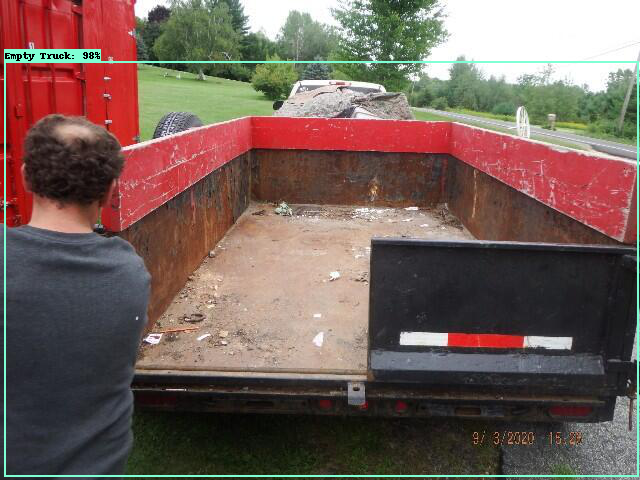

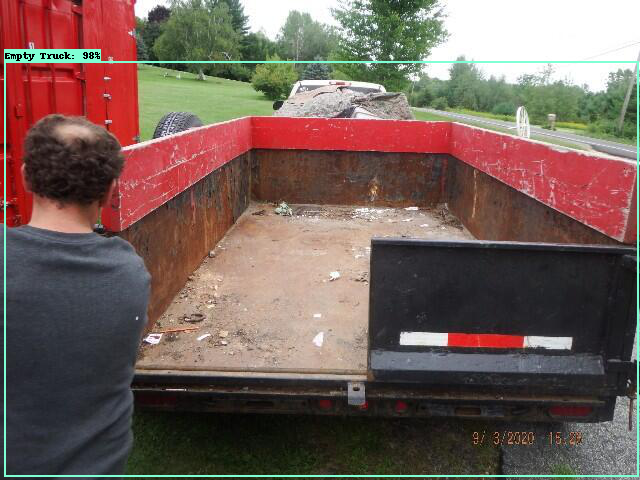

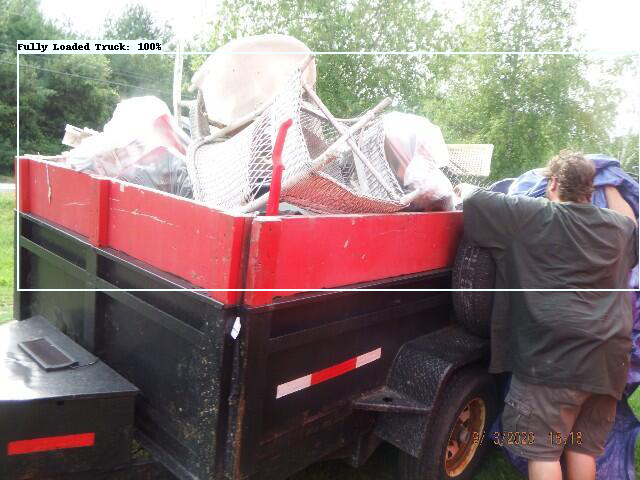

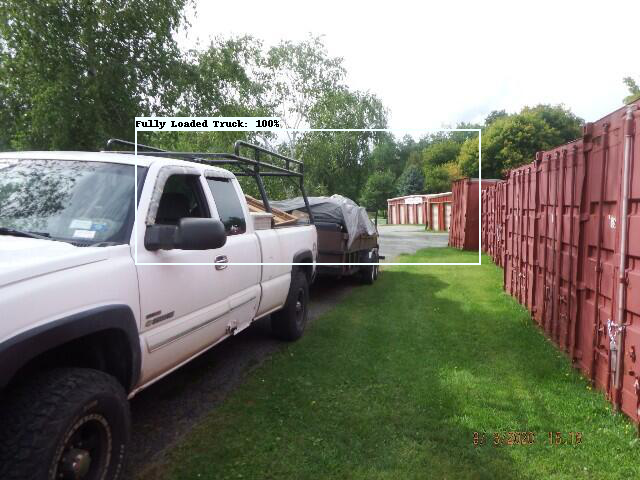

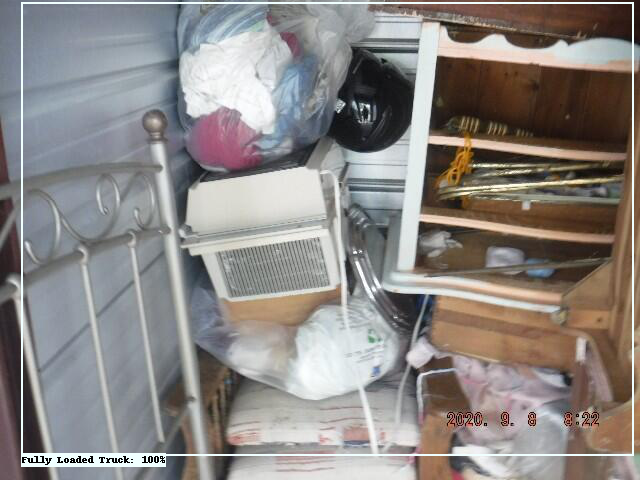

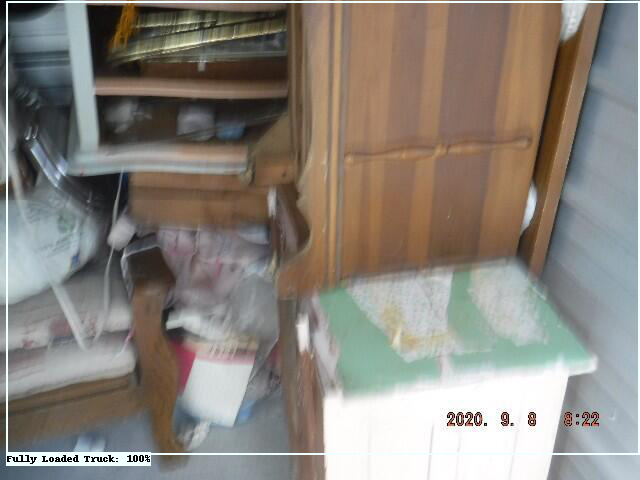

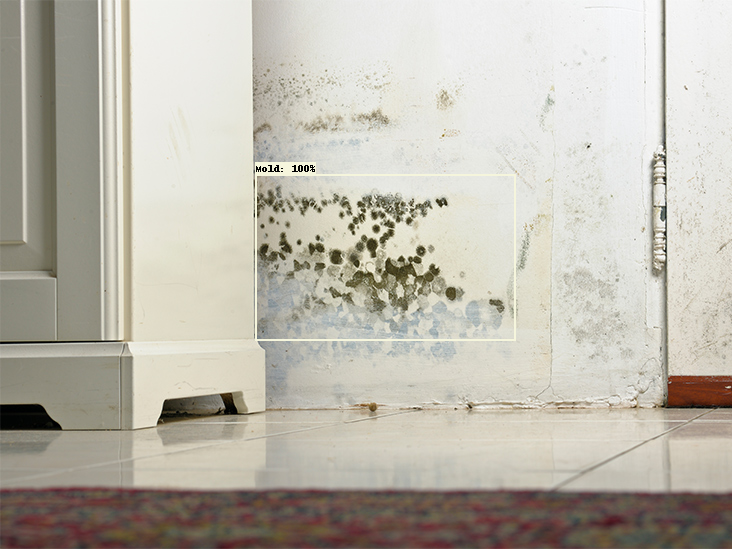

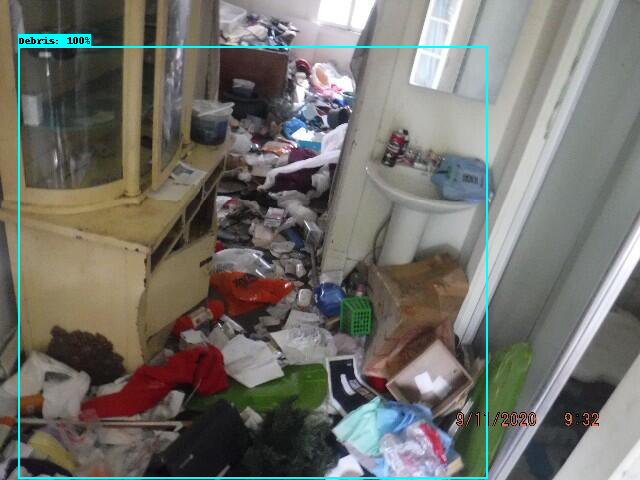

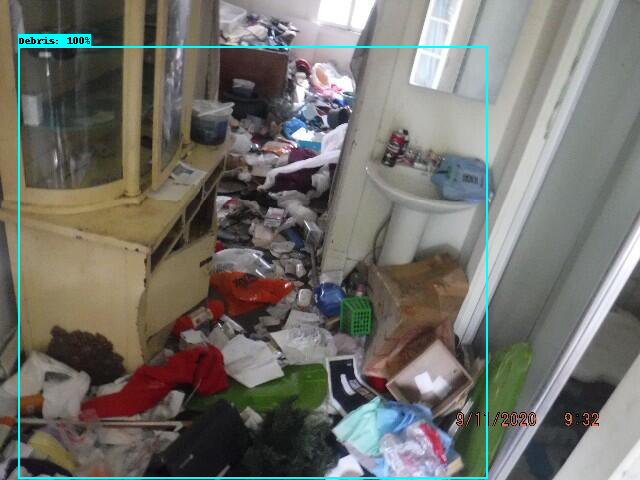

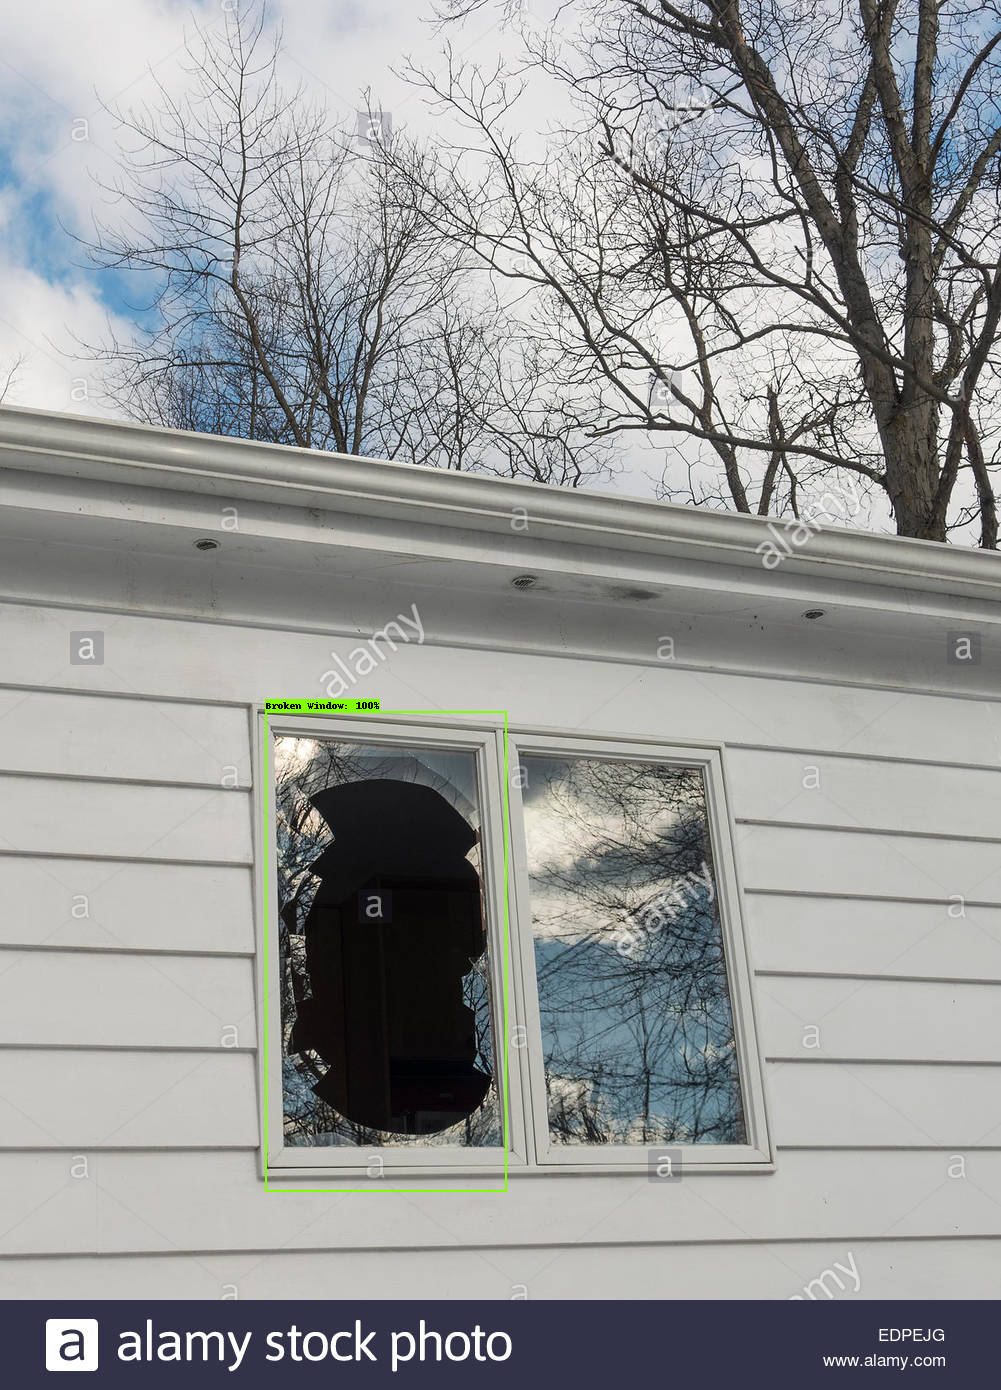

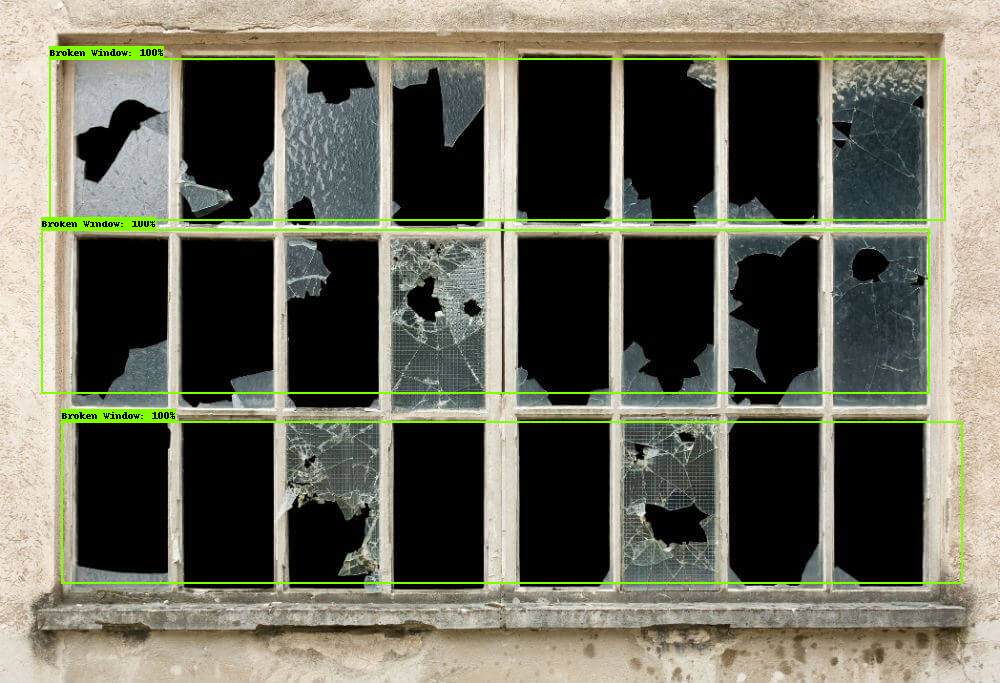

In [ ]:
#this loop run untill the images in folder is finished
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)